In [1]:
# Basic Libraries
import pandas as pd
import modin.pandas as n_pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import random
import os

# Datatable Import
import datatable as dt

# Deep Learning Pytorch Library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
torch.cuda.is_available()
torch.cuda.empty_cache()

In [2]:
# Seed
seed = 123
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
torch.use_deterministic_algorithms(True)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
random.seed(seed)

# Seed for DataLoader
def seed_worker(worker_id):
    worker_seed = 123
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Import Dataset Features and Labels

Both datasets are pre-processed and concatenated, using different code snipets.

In [3]:
# Import using datatable
X = dt.fread("X.csv")
Y = dt.fread("Y.csv")

# Convert to pandas
X = X.to_pandas()
Y = Y.to_pandas()

In [4]:
# Normalize the dimensions part of the X vector
X.iloc[:,6:(X.shape[1]+1)] = scaler.fit_transform(X.iloc[:,6:(X.shape[1]+1)])

# Create Variable Type and Give to a DataLoader
The dataloader will allow to create batches to feed the network smoothly

In [5]:
# Define all dataset for train
all_dataX = Variable(torch.Tensor(X.values)) # .cuda()
all_dataY = Variable(torch.Tensor(Y.values)) # .cuda()

# Delete X and Y from memory
del X
del Y

In [6]:
# Create the Dataset
ds = TensorDataset(all_dataX, all_dataY)
del all_dataX, all_dataY

In [7]:
# Define the batch size
BatchSize = 10000

g = torch.Generator()
g.manual_seed(123)

# Create the DataLoader
dl = DataLoader(ds, batch_size=BatchSize, shuffle=False, num_workers= 8, pin_memory=True, drop_last=True, generator=g, worker_init_fn= seed_worker) #shuffle was at false

# Model LSTM OTA1 (lna1)
The model is a LSTM neural network followed by 2 fully connected layers.  
For that purpose the PyTorch library is used.

In [21]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size):
        super(LSTM, self).__init__()
        
        # Define Variables to be used in the "forward" path
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_init_states = int(batch_size/2)

        # initialize the hidden and cell states - Stateful LSTM
        self.hn = Variable(torch.zeros(1, self.batch_init_states, 450).cuda())
        self.cn = Variable(torch.zeros(1, self.batch_init_states, 450).cuda())
        
        # Define the layers that will be used
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # LSTM Layer
        self.fc1 = nn.Linear(hidden_size + 28, 250) # First Linear layer (+ 28 because of the 28 features for the dimensions for the devices) 250
        self.elu = nn.ELU() # Activation function to allows the model to destinguish de dimensions
        self.dropout = nn.Dropout(p = 0.1) # Dropout to regularization
        self.fc2 = nn.Linear(250, num_classes) # Second Linear Layer
        self.fc3 = nn.Linear(28,num_classes)
        
    def forward(self, x, dimensions):
        
        # Propagate the input through LSTM module
        ula, (self.hn, self.cn) = self.lstm(x, (self.hn.cuda(), self.cn.cuda()))
             
        # Ajust lstm output shape
        hn_out = (self.hn).view(-1, self.hidden_size)

        # Concatenate the lstm output and the dimension vector
        in_fc = torch.cat((hn_out.cuda(), dimensions.cuda()), dim=1).cuda()

        # Propagate the data through the fully conected layers
        out = self.fc1(in_fc)
        out = self.elu(out)
        out = self.fc2(out) 

        return out

## Instanciate the Model, Criterion and Optimizer

In [22]:
# Define the Model with the input parameters
lstm = LSTM(num_classes=2, input_size=2, hidden_size=450, num_layers=1, batch_size= BatchSize).cuda() #have 450!!
lstm = torch.nn.DataParallel(lstm, device_ids=[0,1]).cuda()

# Define the Criterion: mean-squared error loss since we are working with regression problem
criterion = torch.nn.MSELoss()

# Define the Optimizer
optimizer = torch.optim.AdamW(lstm.parameters(), lr=0.00005)

# Adaptative Learning Rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.7, patience=2, min_lr = 0.000001)

# Print the model structure
summary(lstm)

Layer (type:depth-idx)                   Param #
DataParallel                             --
├─LSTM: 1-1                              --
│    └─LSTM: 2-1                         817,200
│    └─Linear: 2-2                       119,750
│    └─ELU: 2-3                          --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       502
│    └─Linear: 2-6                       58
Total params: 937,510
Trainable params: 937,510
Non-trainable params: 0

# Train the Model

In [23]:
# Define the number of epochs
number_of_epochs = 20

# Define the start time 
start_time = time.time()

# Variable to store the losses per epoch
losses = []
errors = []

# Instanciate that the model is in training mode
lstm.train()

# For every epoch defined...
for epoch in range(number_of_epochs):
    
    # Feed data in batches
    for batch_features, batch_labels in dl:
        
        # Extract input waves from all batch, reshape to (xxx,3,2) and send to cuda
        input_waves = batch_features[:,0:6]
        input_waves = input_waves.reshape(input_waves.shape[0], input_waves.shape[1] // 2, 2)
        input_waves = input_waves.cuda()

        # Extract the dimensions from all batch
        input_dimensions = batch_features[:,6:(batch_features.shape[1]+1)]
        input_dimension = input_dimensions.cuda()

        # Pass batch labels to GPU
        batch_labels = batch_labels.cuda()

        # Initialize the gradient to avoid value agregations
        optimizer.zero_grad()       

        # enable autocasting for forward pass
        # * speeds up linear math operations
        # * speeds up memory-limited operations by acessing to half of bytes compared to single precision
        # * reduces memory rrequirements for training models
        with autocast():
            # Predict the model using the training set
            y_pred = lstm(input_waves, input_dimensions)

            # Obtain the loss and the error
            loss = criterion(y_pred, batch_labels)
            error = y_pred - batch_labels
        
        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm = 0.25) # gradient cliping to avoid exploding gradients
        optimizer.step()

    # Append the losses to make the plot
    losses.append(loss.item())
    
    # Append the errors to obtain the metrics to create the noise
    errors.append(error)

    # Adaptative Learning Rate
    scheduler.step(loss)
    
    # Print the results
    if epoch % 2 == 0:
        print("-----> Epoch: %d, ----->loss: %.5E" % (epoch, loss.item()))
        print("Learning Rate: %.6E " % optimizer.param_groups[0]["lr"])
            
# Print the execution time
print(f'\nDuration: {(time.time() - start_time)/60:.0f} Min')

-----> Epoch: 0, ----->loss: 6.33861E-03
Learning Rate: 5.000000E-05 
-----> Epoch: 2, ----->loss: 2.43615E-03
Learning Rate: 5.000000E-05 
-----> Epoch: 4, ----->loss: 2.21910E-03
Learning Rate: 5.000000E-05 
-----> Epoch: 6, ----->loss: 2.27093E-03
Learning Rate: 5.000000E-05 
-----> Epoch: 8, ----->loss: 2.04750E-03
Learning Rate: 3.500000E-05 
-----> Epoch: 10, ----->loss: 1.98089E-03
Learning Rate: 3.500000E-05 
-----> Epoch: 12, ----->loss: 1.81319E-03
Learning Rate: 3.500000E-05 
-----> Epoch: 14, ----->loss: 1.53125E-03
Learning Rate: 3.500000E-05 
-----> Epoch: 16, ----->loss: 1.37524E-03
Learning Rate: 3.500000E-05 
-----> Epoch: 18, ----->loss: 1.27999E-03
Learning Rate: 3.500000E-05 

Duration: 57 Min


In [27]:
errors_new = torch.stack(errors,dim = 0).cpu().data.numpy()
errors_new.shape

(20, 10000, 2)

In [31]:
errors_mean = np.mean(errors_new)
errors_stdv = np.std(errors_new)
print(errors_mean)
print(errors_stdv)

-0.004383777
0.046118375


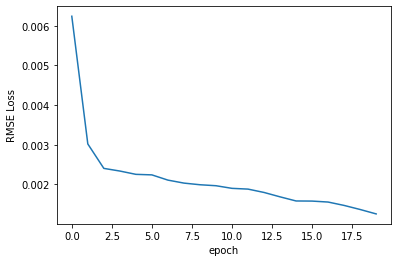

In [ ]:
# Plot the losses along the epochs
with torch.no_grad():
    # If the train ends normaly
    if epoch == number_of_epochs:
        plt.plot(range(epoch+1), losses)    
        plt.ylabel('RMSE Loss')
        plt.xlabel('epoch');
        
    # If the train is shut down 
    else:
        plt.plot(range(epoch+1), losses)    
        plt.ylabel('RMSE Loss')
        plt.xlabel('epoch');

# Save the Model

In [ ]:
torch.save({
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/home/aamaral/Desktop/BigDataset/Evaluation/Final_3.pt')